# Residual Neural Network

Sono usate per il riconoscimento nelle immagini: computer vision.
Sono un tipo di convolutional neural network.
![CNN](https://docs.ecognition.com/Resources/Images/ECogUsr/UG_CNN_scheme.png)

## Layer di pooling
Riducono la dimensione dell'immagine, e quindi il numero di parametri da calcolare.
![Pooling layer](https://nico-curti.github.io/NumPyNet/NumPyNet/images/maxpool.gif)

## Convolutional layer
![Convolutional layer](https://miro.medium.com/max/720/1*Fw-ehcNBR9byHtho-Rxbtw.gif)

## Residual layer
![Residual layer](https://miro.medium.com/v2/resize:fit:720/1*lD7eU_KynLT8xTh0vfRd7g.gif)

# Pre-trained models
Pytorch ha molti modelli pre-trained, che possono essere usati per fare transfer learning. Sono molto diffusi, e sono usati anche in produzione. Ad esempio GPT-3 è un modello pre-trained. Questi hanno poi applicazioni generiche, anche se sono stati allenati su un dataset specifico.
![Pre-trained models](https://i.ytimg.com/vi/8ZWMQcd7KSo/maxresdefault.jpg)


In [147]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
from torchvision import transforms
import time
from tqdm.autonotebook import tqdm
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import inspect

import matplotlib.pyplot as plt
import numpy as np

## Load data
Userò un open-dataset di immagini: il dataset Mnist, che contiene diversi capi di abbigliamento. Qui lo scarico.
Creo dei dataloaders, in modo da essere più efficiente nel caricare i dati. Inoltre così posso fare il training in batch.

In [148]:
portion = 0.01

In [149]:
def get_data_loaders(train_batch_size, val_batch_size):
    fashion_mnist = torchvision.datasets.FashionMNIST(download=True, train=True, root="data").train_data.float()

    data_transform = transforms.Compose([ transforms.Resize((224, 224)),
                                          transforms.ToTensor(),
                                          transforms.Normalize((fashion_mnist.mean()/255,), (fashion_mnist.std()/255,))])
    # sampler to keep only 10% of the data
    train_loader = DataLoader(torchvision.datasets.FashionMNIST(download=True, root="data", transform=data_transform, train=True),batch_size=train_batch_size, sampler=SubsetRandomSampler(list(range(0, 50000, int(1/portion)))))

    val_loader = DataLoader(torchvision.datasets.FashionMNIST(download=False, root="data", transform=data_transform, train=False),batch_size=val_batch_size, sampler=SequentialSampler(list(range(0, 10000, int(1/portion)))))

    return train_loader, val_loader

## Scelgo il device da usare
Posso volendo usare la GPU(nvidia CUDA) per trainare l'AI più velocemente

In [150]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


## Definisco il modello
Qui è dove scelgo le specifiche del modello. Nel questo caso creo una ResNet, residual neural network.

In [151]:
class MnistResNet(nn.Module):
    def __init__(self, in_channels=1):
        super(MnistResNet, self).__init__()

        # Load a pretrained resnet model from torchvision.models in Pytorch
        self.model = models.resnet50(pretrained=True)

        # Change the input layer to take Grayscale image, instead of RGB images.
        # Hence in_channels is set as 1 or 3 respectively
        self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Change the output layer to output 10 classes instead of 1000 classes
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 10)

    def forward(self, x):
        return self.model(x)


my_resnet = MnistResNet()

Controllo il contenuto effettivo del modello

In [152]:
input = torch.randn((16,1,244,244))
output = my_resnet(input)
print(output.shape)

print(my_resnet)

torch.Size([16, 10])
MnistResNet(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample):

## Definisco le funzioni per calcolare le metriche

In [153]:
def calculate_metric(metric_fn, true_y, pred_y):
    if "average" in inspect.getfullargspec(metric_fn).kwonlyargs:
        return metric_fn(true_y, pred_y, average="macro")
    else:
        return metric_fn(true_y, pred_y)

def print_scores(p, r, f1, a, batch_size):
    for name, scores in zip(("precision", "recall", "F1", "accuracy"), (p, r, f1, a)):
        print(f"\t{name.rjust(14, ' ')}: {sum(scores)/batch_size:.4f}")

## Pytorch training boilerplate

In [154]:
# model:
model = MnistResNet().to(device)

# params you need to specify:
epochs = 5
batch_size = 50

# Dataloaders
train_loader, val_loader = get_data_loaders(batch_size, batch_size)

# loss function and optimiyer
loss_function = nn.CrossEntropyLoss() # your loss function, cross entropy works well for multi-class problems

# optimizer, I've used Adadelta, as it wokrs well without any magic numbers
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) # Using Karpathy's learning rate constant

start_ts = time.time()

losses = []
validation_losses = []
batches = len(train_loader)
val_batches = len(val_loader)

# loop for every epoch (training + evaluation)
for epoch in range(epochs):
    total_loss = 0

    # progress bar (works in Jupyter notebook too!)
    progress = tqdm(enumerate(train_loader), desc="Loss: ", total=batches)

    # ----------------- TRAINING  --------------------
    # set model to training
    model.train()

    for i, data in progress:
        X, y = data[0].to(device), data[1].to(device)

        # training step for single batch
        model.zero_grad()
        outputs = model(X)
        loss = loss_function(outputs, y)
        loss.backward()
        optimizer.step()

        # getting training quality data
        current_loss = loss.item()
        total_loss += current_loss
        losses.append(current_loss)

        # updating progress bar
        progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))

    # releasing unceseccary memory in GPU
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # ----------------- VALIDATION  -----------------
    val_losses = 0
    precision, recall, f1, accuracy = [], [], [], []

    # set model to evaluating (testing)
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            X, y = data[0].to(device), data[1].to(device)

            outputs = model(X) # this get's the prediction from the network

            current_loss = loss_function(outputs, y)
            val_losses += current_loss
            validation_losses.append(current_loss.item())

            predicted_classes = torch.max(outputs, 1)[1] # get class from network's prediction

            # calculate P/R/F1/A metrics for batch
            for acc, metric in zip((precision, recall, f1, accuracy),
                                   (precision_score, recall_score, f1_score, accuracy_score)):
                acc.append(
                    calculate_metric(metric, y.cpu(), predicted_classes.cpu())
                )

    print(f"Epoch {epoch+1}/{epochs}, training loss: {total_loss/batches}, validation loss: {val_losses/val_batches}")
    print_scores(precision, recall, f1, accuracy, val_batches)

print(f"Training time: {time.time()-start_ts}s")

Loss:   0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\samue\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/5, training loss: 1.1987056612968445, validation loss: 1.6758346557617188
	     precision: 0.3728
	        recall: 0.3821
	            F1: 0.3118
	      accuracy: 0.3500


C:\Users\samue\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Loss:   0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\samue\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/5, training loss: 0.46001050174236296, validation loss: 1.530922770500183
	     precision: 0.4898
	        recall: 0.4759
	            F1: 0.4228
	      accuracy: 0.4900


C:\Users\samue\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Loss:   0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\samue\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samue\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/5, training loss: 0.25922216325998304, validation loss: 1.6386961936950684
	     precision: 0.5033
	        recall: 0.4705
	            F1: 0.3878
	      accuracy: 0.5100


Loss:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4/5, training loss: 0.17252228036522865, validation loss: 0.7910810112953186
	     precision: 0.7339
	        recall: 0.6958
	            F1: 0.6797
	      accuracy: 0.7400


Loss:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5/5, training loss: 0.09271550346165895, validation loss: 0.6177794337272644
	     precision: 0.7985
	        recall: 0.7546
	            F1: 0.7514
	      accuracy: 0.7900
Training time: 2341.821244239807s


# plot the losses

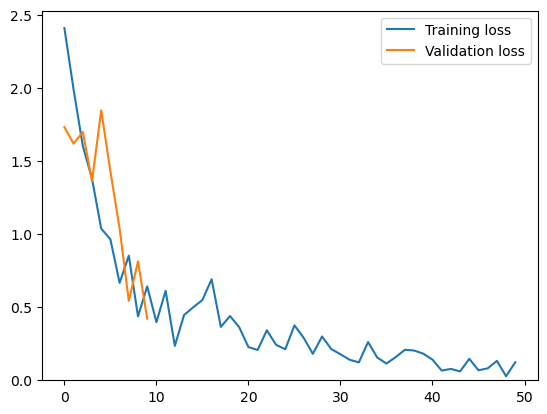

In [157]:
plt.plot(losses, label='Training loss')
plt.plot(validation_losses, label='Validation loss')
plt.legend()
# start y from 0
plt.ylim(bottom=0)
plt.show()

In [156]:
if False: # manual switch
    torch.save(model.state_dict(), "data/MnistResNet")
    model = MnistResNet()
    model_state_dict = torch.load("data/MnistResNet")
    model.load_state_dict(model_state_dict)

C:\Users\samue\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\samue\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
